# Supernova distances and redshift

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

We now have a suite of *data-drive predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fir it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy?

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import generate_mu_z
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm
import itertools
from scipy.integrate import quad
import emcee
import scipy.stats as scistats
import corner
import dynesty
import time
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from matplotlib.colors import ListedColormap
from scipy.stats import uniform
from astropy.cosmology import LambdaCDM
from scipy.stats import kendalltau
from math import pi
from bokeh.plotting import figure, output_file, show

Collect the data

(35.0, 50.0)

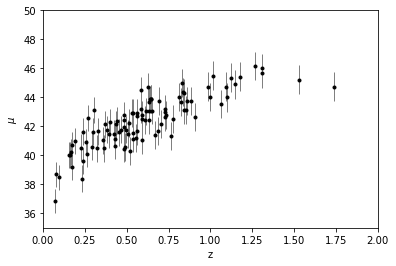

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)
z = np.linspace(0.01, 2, 100)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

In [3]:
# cross validation for kernel hyperparameter 

X=z_sample[:,np.newaxis]
y=mu_sample

def cross_val_kernel(kernels, X, Y):
    performance = {}
    
    for kernel in tqdm(kernels): 
        likelihood = 0
        for i in range(Y.size):
            gp = GaussianProcessRegressor(kernel = kernel)
            X_train = np.delete(X, i, axis=0)
            Y_train = np.delete(Y, i, axis=0)
            gp.fit(X_train, Y_train)
            y_mean, y_std = gp.predict(X[[i], :], return_std = True)
            likelihood += -np.log(y_std[0]) - (Y[i] - y_mean[0])**2 / (2 * y_std[0]**2)
            
        performance[likelihood] = kernel
        
    return performance

parRange = [np.arange(0.5, 2, 0.2), np.arange(5, 15, 1)] # , np.arange(0.1, 1, 0.1)
kernels = [ConstantKernel(a) * RBF(b) for a, b in list(itertools.product(*parRange))] #  WhiteKernel(c)

performance = cross_val_kernel(kernels, X, y)

best_key = np.max(list(performance.keys()))

print('best kernel hyperparameters = ', performance[best_key])

 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [12:31<02:27,  9.19s/it]C:\Users\PC\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [15:03<00:00, 11.29s/it]

best kernel hyperparameters =  1.05**2 * RBF(length_scale=14)


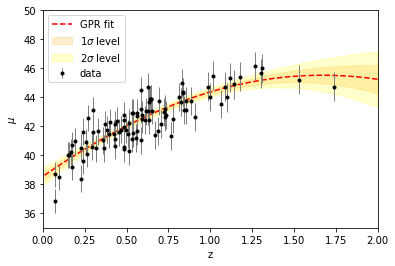

In [4]:
# Gaussian Process regression GPR

X=z[:,None]
gpr= GaussianProcessRegressor(kernel=(ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))), alpha=dmu ** 2)
gpr.fit(z_sample[:,None],mu_sample)

y_pred, std_y_pred = gpr.predict(X, return_std=True)

plt.plot(z,y_pred,'r--', label='GPR fit')
plt.fill_between(z, y_pred - std_y_pred, y_pred + std_y_pred, color="orange", alpha=0.2, label=r'$1\sigma$ level')
plt.fill_between(z, y_pred - 2*std_y_pred, y_pred + 2*std_y_pred, color="yellow", alpha=0.2, label=r'$2\sigma$ level')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(loc=0)
plt.show()

Define the model functional form. model comes from astropy libraries while func is get from the book

In [4]:

def model(z, H0, Om=1):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value #note I added .value here. Astropy units can be funny.

In [6]:
def func(x,omega_m,H0):
    fn = lambda t: 1/(np.sqrt(omega_m*(1+t**3)+0.69))
    integral = np.asarray([quad(fn, 0, _x)[0] for _x in x])
    mu = 5*np.log(((3*10**5)/H0)/1 * (1+x) * list(integral))
    return mu

<ipython-input-6-f3dcff0969ec>:4: RuntimeWarning: divide by zero encountered in log
  mu = 5*np.log(((3*10**5)/H0)/1 * (1+x) * list(integral))


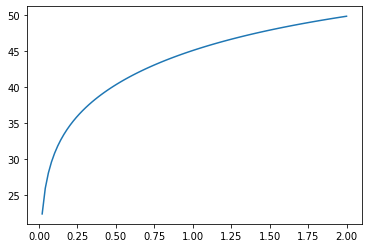

In [7]:
xx=np.linspace(0,2,100)
plt.plot(xx,func(xx,0.31,70))

Parameter estimation with emcee

In [8]:
def LogLikelihood(theta):
    Om,H0 = theta    
    if Om<0:
        return -np.inf
    else:
        mu_model = func(z_sample, H0, Om)
    
    #return np.sum(scistats.norm.logpdf(mu_sample, loc=mu_model, scale=dmu))
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

def Logprior(theta):
    Om,H0 = theta
    if 50 < H0 < 100 and 0.1 < Om < 1:
        return 0.0
    return -np.inf

                   
def LogPosterior(theta):
    return LogLikelihood(theta) + Logprior(theta)

In [9]:
ndim = 2  # number of parameters in the model
nwalkers = 5  # number of MCMC walkers
nsteps = int(1e4)  # number of MCMC steps to take **for each walker**

starting_guesses = np.array([0.5,80]) + 1e-1* np.random.randn(nwalkers, ndim)


print(starting_guesses.shape)

(5, 2)


In [10]:
start=time.time()
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(starting_guesses, nsteps)
stop=time.time()

print("done in %1.3f" % (stop-start))

done in 655.370


autocorrelation time [34.36438317 73.95813305]
(665, 2)


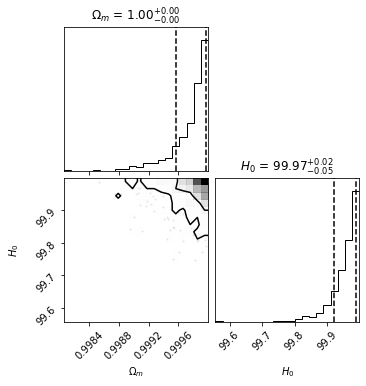

In [11]:
tau = sampler.get_autocorr_time()
print('autocorrelation time' , tau)
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

fig = corner.corner(flat_samples, labels=[r"$\Omega_m$","$H_0$"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71],quantiles=[0.16,0.84])

(35.0, 50.0)

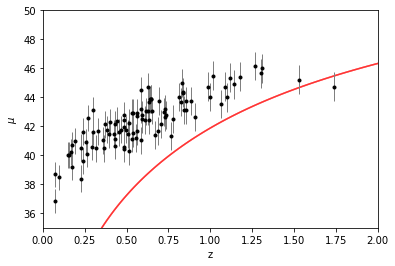

In [12]:
# plot the MCMC par result

zz=np.linspace(0,2,100)[1:]

plt.figure()
for Om,H0 in flat_samples[::100]:
    plt.plot(zz,func(zz,Om,H0), 'r-', alpha=0.2)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

Check the correlation with kenda's coefficent

In [34]:
Ktau,p_value = kendalltau(flat_samples[:,0],flat_samples[:,1])
print("kendal's_tau = %1.3f\n p-value = %1.3f" % (Ktau,p_value))

kendal's_tau = -0.067
 p-value = 0.010


In [7]:
# try with dynesty and the astropy model instead my function

def LogLikelihood(theta):
    Om,H0 = theta    
    if Om<0:
        return -np.inf
    else:
        mu_model = model(z_sample, H0, Om)
    
    #return np.sum(scistats.norm.logpdf(mu_sample, loc=mu_model, scale=dmu))
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    mins = np.array([0.1,30])
    maxs = np.array([1,100])
        
    return  mins + u*(maxs-mins)

sampler = dynesty.NestedSampler(LogLikelihood, ptform, ndim=2,nlive=1000)
sampler.run_nested()
sresults = sampler.results





2819it [00:41, 67.54it/s, +1000 | bound: 0 | nc: 1 | ncall: 16252 | eff(%): 23.499 | loglstar:   -inf < -132.814 <    inf | logz: -135.347 +/-  0.032 | dlogz:  0.001 >  1.009]


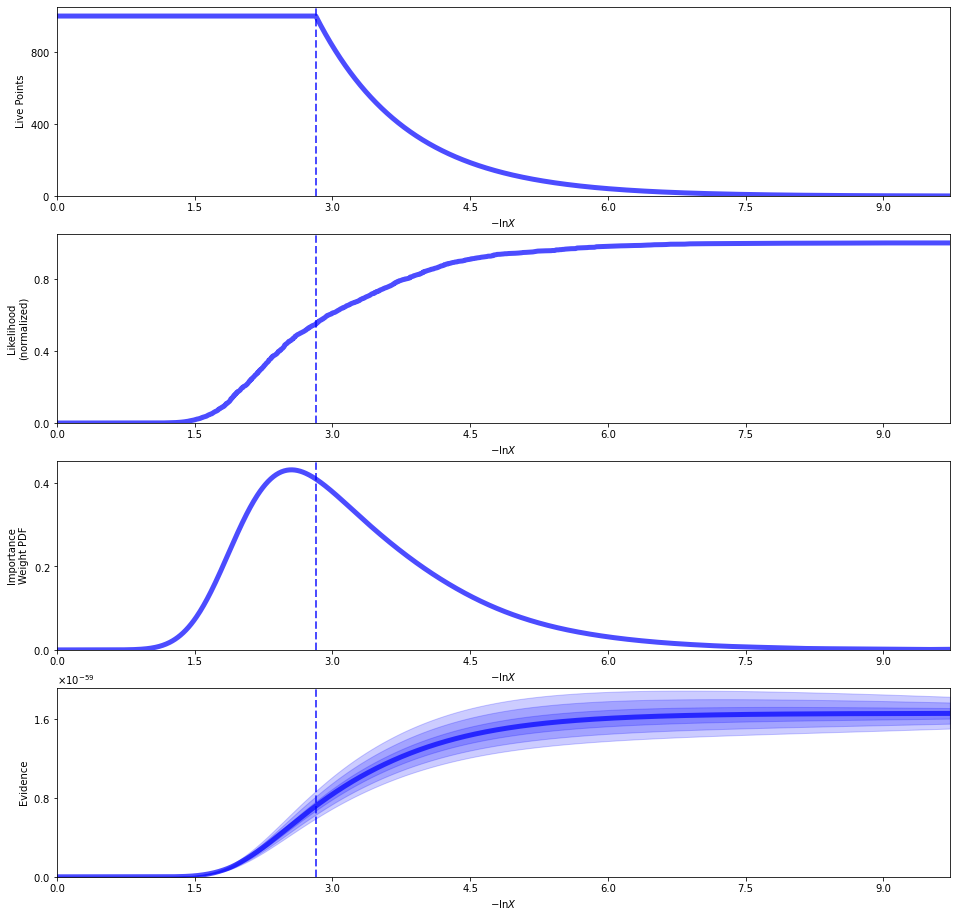

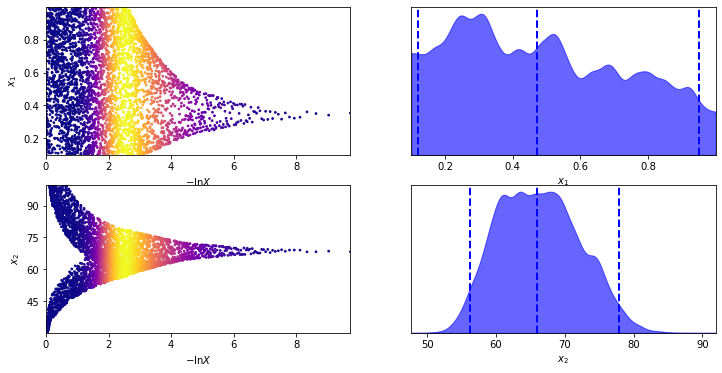

In [8]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults)

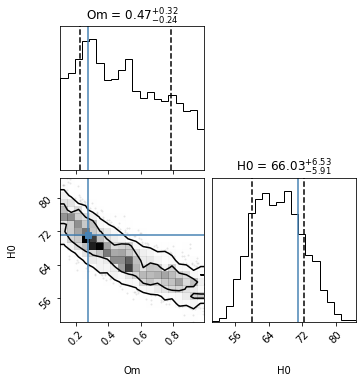

In [9]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
samples_equal = dyfunc.resample_equal(samples, weights)
fig = corner.corner(
    samples_equal, labels=["Om","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71],quantiles=[0.16,0.84])

Dynesty works better and quckly

(35.0, 50.0)

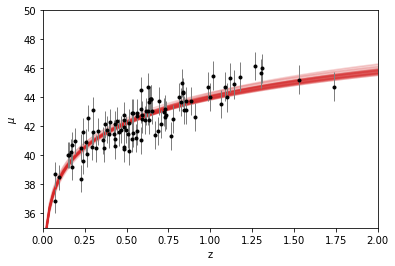

In [17]:
for Om,H0, in samples_equal[::100]:
    plt.plot(zz, model(zz, H0, Om),c='C3',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

Let's try PCA to check correlation between cosmological params

[1.05707535e-14 1.28567257e-14]
initial covariance [[ 0.06 -1.23]
 [-1.23 34.17]]
fraction of variance in each component [0.9274101 0.0725899]
amount of variance in each component [1.85530601 0.14521783]


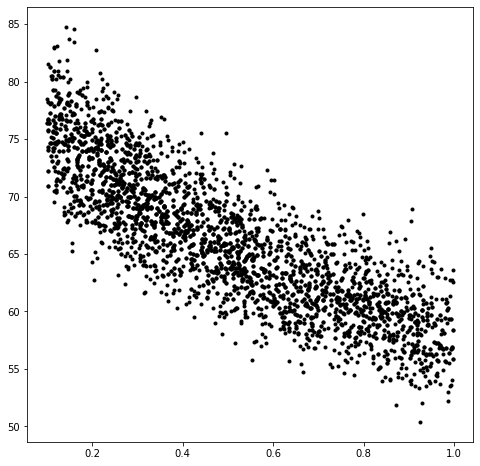

In [11]:
plt.figure(figsize=(8,8))
plt.scatter(samples_equal[:,0],samples_equal[:,1],color='black',marker='.')

sc = StandardScaler()
sc.fit(samples_equal)
X_new=sc.transform(samples_equal)

pca = PCA(n_components=2)
pca.fit(X_new)

evals = pca.transform(X_new)
evecs = pca.components_
means = pca.mean_
print(means)

mean_data = samples_equal - means
cov = np.cov(mean_data.T)
cov = np.round(cov, 2)
print('initial covariance',cov) # how much the variables are correlated at the beginning

# After pca decomposition...

print('fraction of variance in each component', pca.explained_variance_ratio_)
print('amount of variance in each component', pca.explained_variance_)

# Xreconstruction = means + evecs*evals[0] # 1 comp

In [19]:
# let me try a simple Bokeh visualization

output_file('PCA_dec.html')

p = figure(width=400, height=400)
# add a circle renderer with a size, color, and alpha
p.circle(evals[:,0], evals[:,1], size=10, color="navy", alpha=0.5)

show(p)

Plot mock samples. GPR are data driven

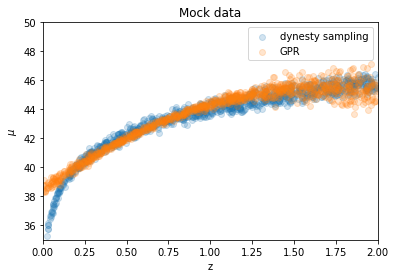

In [20]:
# Part 4

z_vals = np.random.uniform(0,2,1000)
mu_mcmc = []
mu_gpr=[]

for i in range(len(z_vals)):
    omega_matter,H_0 = np.random.choice(samples_equal[:,1]), np.random.choice(samples_equal[:,0])
    mu_model=model(z_vals[i],omega_matter,H_0)
    mu_mcmc.append(mu_model)

mu_pred, dmu = gpr.predict(z_vals[:,np.newaxis], return_std=True)
mu_gpr.append(np.random.normal(loc=mu_pred, scale=dmu))

plt.figure()    
plt.scatter(z_vals,mu_mcmc,alpha=0.2,label="dynesty sampling")
plt.scatter(z_vals,mu_gpr[0],alpha=0.2,label='GPR')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title("Mock data")
plt.legend(loc=0)   

Repeat params estimation in the case we haven't DE

2767it [00:37, 74.74it/s, +1000 | bound: 0 | nc: 1 | ncall: 17184 | eff(%): 23.276 | loglstar:   -inf < -133.530 <    inf | logz: -135.916 +/-    nan | dlogz:  0.001 >  1.009]


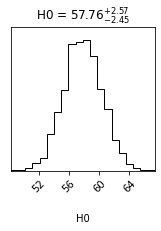

In [21]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

def generativemodel(z, H0, Om=1):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value #note I added .value here. Astropy units can be funny.

def LogLikelihood_mod(theta):

    H0 = float(theta)    
    Om=1
    mu_model = generativemodel(z_sample, H0, Om)
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

ndim  =1

def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""
    mins = np.array([30.])
    maxs = np.array([100.])
        
    return  mins + u*(maxs-mins)

sampler_mod = dynesty.NestedSampler(LogLikelihood_mod, ptform, ndim,nlive=1000)
sampler_mod.run_nested()
sresults_mod = sampler_mod.results


#Extract sampling results.
samples = sresults_mod.samples  # samples
weights = np.exp(sresults_mod.logwt - sresults_mod.logz[-1])  # normalized weights

# Resample weighted samples.
samples_equal_mod = dyfunc.resample_equal(samples, weights)

fig = corner.corner(samples_equal_mod, labels=["H0"], levels=[0.68,0.95], show_titles=True, truths=[71])

In [26]:
# Compute 10%-90% quantiles.
quantiles_mod = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights) for samps in samples_equal_mod.T]
print('68% parameter credible regions are:\n ' + str(quantiles_mod) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples_equal_mod, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))



68% parameter credible regions are:
 [[55.383895723559384, 60.36007844074744]]

Mean and covariance of parameters are: [57.82816083]
[[6.33998996]]


(35.0, 50.0)

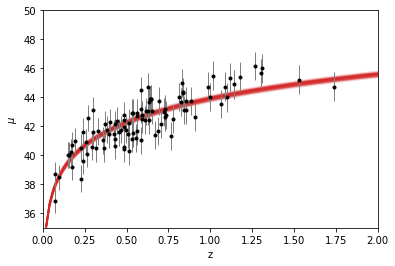

In [27]:
for H0 in samples_equal_mod[::100]:
    plt.plot(zz, model(zz, float(H0), 1),c='C3',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

Let me compute odds ratio to determine the best model, as we can see neither the firts nor the second without DE are preferred to describe the data

In [35]:
# let me compare the models throught odds ratio assumig equal hyperpriors

logevratio  = sresults.logz[-1]-sresults_mod.logz[-1]

print(logevratio/np.log(10), np.exp(logevratio))



0.24838136546610945 1.7716640204611898
